<a href="https://colab.research.google.com/github/mgxbreu/NLP_sentiment_analysis/blob/main/NLP_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
!pip install py3langid
import pandas as pd
import json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 KB 14.7 MB/s eta 0:00:00


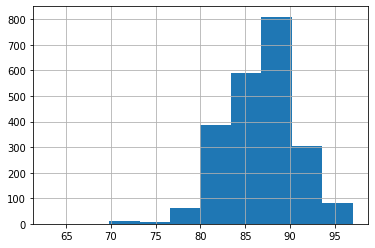

In [4]:
df = pd.read_csv("scotch_review.csv")
df['review.point'].hist()

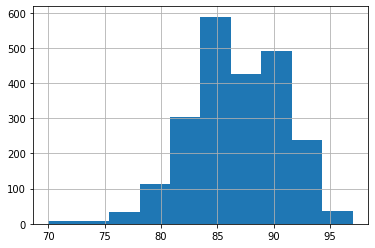

In [5]:
#Downsize removing data from the right 
df = df[df['review.point'] >=70]
df['review.point'].hist()

In [ ]:
#Check if there's null values
df.isnull().sum()

Unnamed: 0      0
name            0
category        0
review.point    0
price           0
currency        0
description     0
dtype: int64

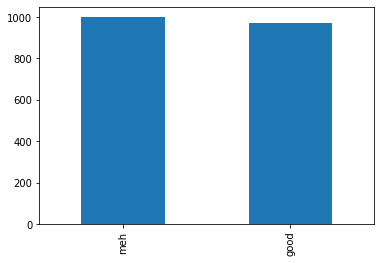

In [120]:
df["quality"] = df["review.point"].map(lambda x : "good" if x >= 88 else "meh")
df["quality"].value_counts().plot.bar()

In [121]:
#Choose 1000 samples from meh quality to downsize the data
meh = df[df["quality"] == "meh"].sample(1000)
good =  df[df["quality"] == "good"]

In [85]:
df = pd.concat([meh, good])
df = df.sample(frac=1).reset_index(drop=True)

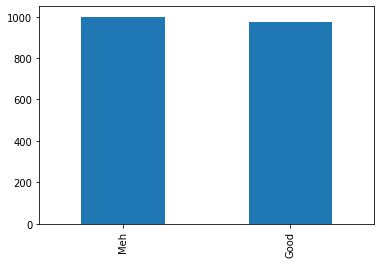

In [86]:
df["quality"].value_counts().plot.bar()

In [95]:
# Extracting language

import py3langid as langid

df["language"] = df["description"].apply(lambda x : langid.classify(x)[0])
df[df["language"] != "en"][["language", "description"]]


,language,description


# Preprocessing text

In [113]:
#Loading libraries
import nltk
from nltk import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download([
    "stopwords",
    "names",
    "vader_lexicon",
    "punkt",
    "wordnet",
    "omw-1.4",
    "averaged_perceptron_tagger"])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [122]:

# Getting english stopwords
stopwords = nltk.corpus.stopwords.words("english")
names = nltk.corpus.names.words()

# Base token extraction function

def get_tokens(series, reduce):

    """
    reducer is a function the either lemmatizes or stems the token
    """

    vocabulary = []
    for comment in series:
        #print(comment)
        #print(nltk.word_tokenize(comment))
        for idx, word in enumerate(nltk.word_tokenize(comment)):
            #print("")
            #print(idx, word)
            if not word.isalpha(): continue
            #print("PASO LA VALIDACION DE TEXTO")
            if word in stopwords: continue
            #print("NO ES UN STOPWORD")
            #if idx != 0: word = word.lower()
            if word not in names: word = word.lower()
            #print(word)
            vocabulary.append(reduce(word))
            #print(reduce(word))
            #print("PALABRA AGREGADA LA VOCABULARIO")
            

    return vocabulary
  
#Getting tokens of vocabulary and lemmatizing

lemmatizer = WordNetLemmatizer()

# Getting word vocabulary
vocabulary = get_tokens(df["description"][:10], lemmatizer.lemmatize)
# Getting common unigrams

fd = nltk.FreqDist(vocabulary)
# fd.tabulate(10)

# Getting common bigrams

finder = nltk.collocations.BigramCollocationFinder.from_words(vocabulary)
# finder.ngram_fd.tabulate(10)

# Getting common trigrams

finder = nltk.collocations.TrigramCollocationFinder.from_words(vocabulary)
# finder.ngram_fd.tabulate(10)

# Getting common quadgrams

finder = nltk.collocations.QuadgramCollocationFinder.from_words(vocabulary)
finder.ngram_fd.tabulate(10)

('imagine', 'sipping', 'sophisticated', 'libation')  ('sipping', 'sophisticated', 'libation', 'supper')     ('sophisticated', 'libation', 'supper', 'club')            ('libation', 'supper', 'club', 'turned')                ('supper', 'club', 'turned', 'best')                   ('club', 'turned', 'best', 'bib')                 ('turned', 'best', 'bib', 'tucker')                  ('best', 'bib', 'tucker', 'there')                ('bib', 'tucker', 'there', 'purity')              ('tucker', 'there', 'purity', 'aroma') 
                                                  1                                                   1                                                   1                                                   1                                                   1                                                   1                                                   1                                                   1                                                   1            

In [123]:
# Defining unwanted features and desired features

unwanted = nltk.corpus.stopwords.words("english")
unwanted.extend([w.lower() for w in nltk.corpus.names.words()])

def skip_unwanted(pos_tuple):
    word, tag = pos_tuple
    if not word.isalpha() or word in unwanted:
        return False
    if tag.startswith("NN"):
        return False
    return True

positive_comments = df[df["quality"] == "good"]["description"]
negative_comments = df[df["quality"] == "meh"]["description"]

positive_tokens = get_tokens(positive_comments, lemmatizer.lemmatize)
negative_tokens = get_tokens(negative_comments, lemmatizer.lemmatize)

positive_words = [word for word, tag in filter(
    skip_unwanted,
    nltk.pos_tag(positive_tokens)
)]
negative_words = [word for word, tag in filter(
    skip_unwanted,
    nltk.pos_tag(negative_tokens)
)]

In [128]:
positive_fd = nltk.FreqDist(positive_words)
negative_fd = nltk.FreqDist(negative_words)

common_set = set(positive_fd).intersection(negative_fd)

for word in common_set:
    del positive_fd[word]
    del negative_fd[word]

top_200_positive = {word for word, count in positive_fd.most_common(100)}
top_200_negative = {word for word, count in negative_fd.most_common(100)}

In [129]:
import pickle

f = open('top_200_positive.pickle', 'wb')
pickle.dump(top_200_positive, f)
f.close()

f = open('top_200_negative.pickle', 'wb')
pickle.dump(top_200_negative, f)
f.close()

# 1. NLTK Pretrained Sentiment Analyzer


In [130]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [131]:
df["quality"].value_counts()

meh     1000
good     972
Name: quality, dtype: int64

In [132]:
df["quality_estimate"] = df["description"].map(lambda x : max(sia.polarity_scores(x), key=sia.polarity_scores(x).get))

In [133]:
df[["description", "quality", "quality_estimate"]]

,description,quality,quality_estimate
0,Imagine sipping this sophisticated libation at...,good,neu
1,Having replaced the 16 year old Longmorn with ...,good,compound
2,Distilled in 2008 from 100 percent Scottish ba...,good,neu
3,"An unusual vintage bottling of Old Pulteney, i...",good,neu
4,"Mature on the nose, mixing the tropical fruits...",meh,compound
...,...,...,...
1967,Deep gold color. Surprisingly lively on the no...,good,compound
1968,If you like warm chocolate ganache sprinkled w...,meh,compound
1969,There has been an excellent streak of Islay bl...,good,compound
1970,"This is the bigger, spicier, and more complex ...",good,neu


# 2. NLTK Naive Bayes Classifier



In [153]:
from statistics import mean

def extract_features(text):

    vocabulary = []
    for idx, word in enumerate(nltk.word_tokenize(text)):
        if not word.isalpha(): continue
        if word in stopwords: continue
        word = word.lower()
        word = lemmatizer.lemmatize(word)
        if word in top_200_negative or top_200_positive:
            vocabulary.append(word)

    fd = nltk.FreqDist(vocabulary)

    return fd

In [136]:
positive_comments = df[df["quality"] == "good"]["description"].sample(200)
negative_comments = df[df["quality"] == "meh"]["description"].sample(200)

features = [
    (extract_features(review), "pos")
    for review in positive_comments
]
features.extend([
    (extract_features(review), "neg")
    for review in negative_comments
])

In [ ]:
from random import shuffle

train_count = len(features)//2
shuffle(features)
classifier = nltk.NaiveBayesClassifier.train(features[:train_count])
classifier.show_most_informative_features(10)

#Checking accuracy

nltk.classify.accuracy(classifier, features[train_count:])

In [142]:
# Testing unseen data

review = "i dont like it"
classifier.classify(extract_features(review))

'neg'

# 3. Scikit-Learn Naive Bayes Classifier

In [143]:
from sklearn.naive_bayes import (
    BernoulliNB,
    ComplementNB,
    MultinomialNB,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [144]:
classifiers = {
    "BernoulliNB": BernoulliNB(),
    "ComplementNB": ComplementNB(),
    "MultinomialNB": MultinomialNB(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression(),
    "MLPClassifier": MLPClassifier(max_iter=1000),
    "AdaBoostClassifier": AdaBoostClassifier(),
}

In [145]:
train_count = len(features) // 4
shuffle(features)

trained_classifiers = {}

for name, sklearn_classifier in classifiers.items():
     classifier = nltk.classify.SklearnClassifier(sklearn_classifier)
     classifier.train(features[:train_count])
     accuracy = nltk.classify.accuracy(classifier, features[train_count:])
     trained_classifiers[name] = classifier
     print(F"{accuracy:.2%} - {name}")

49.33% - BernoulliNB
60.67% - ComplementNB
59.67% - MultinomialNB
50.00% - KNeighborsClassifier
50.33% - DecisionTreeClassifier
49.67% - RandomForestClassifier
57.00% - LogisticRegression
57.67% - MLPClassifier
58.00% - AdaBoostClassifier


# Final touches

In [148]:
# Save best model

import pickle
f = open('sentiment_classifier.pickle', 'wb')
pickle.dump(trained_classifiers["ComplementNB"], f)
f.close()

In [150]:
# Test some values on the classifier 

f = open('sentiment_classifier.pickle', 'rb')
deployed_classifier = pickle.load(f)
f.close()

In [152]:
deployed_classifier.classify(extract_features("hate"))

'neg'